In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
import xgboost as xgb
import seaborn as sns
from xgboost import plot_importance

In [2]:
pd.set_option('display.max_row', None)  # permet d'afficher les dataframes sans restrictions sur les lignes
pd.set_option('display.max_columns', None)  # permet d'afficher les dataframes sans restrictions sur les colonnes

In [3]:
data_features_train = pd.read_csv('X_train_J01Z4CN.csv')
data_target_train = pd.read_csv('y_train_OXxrJt1.csv')
data_features_test = pd.read_csv('X_test_BEhvxAN.csv')

<function matplotlib.pyplot.show(close=None, block=None)>

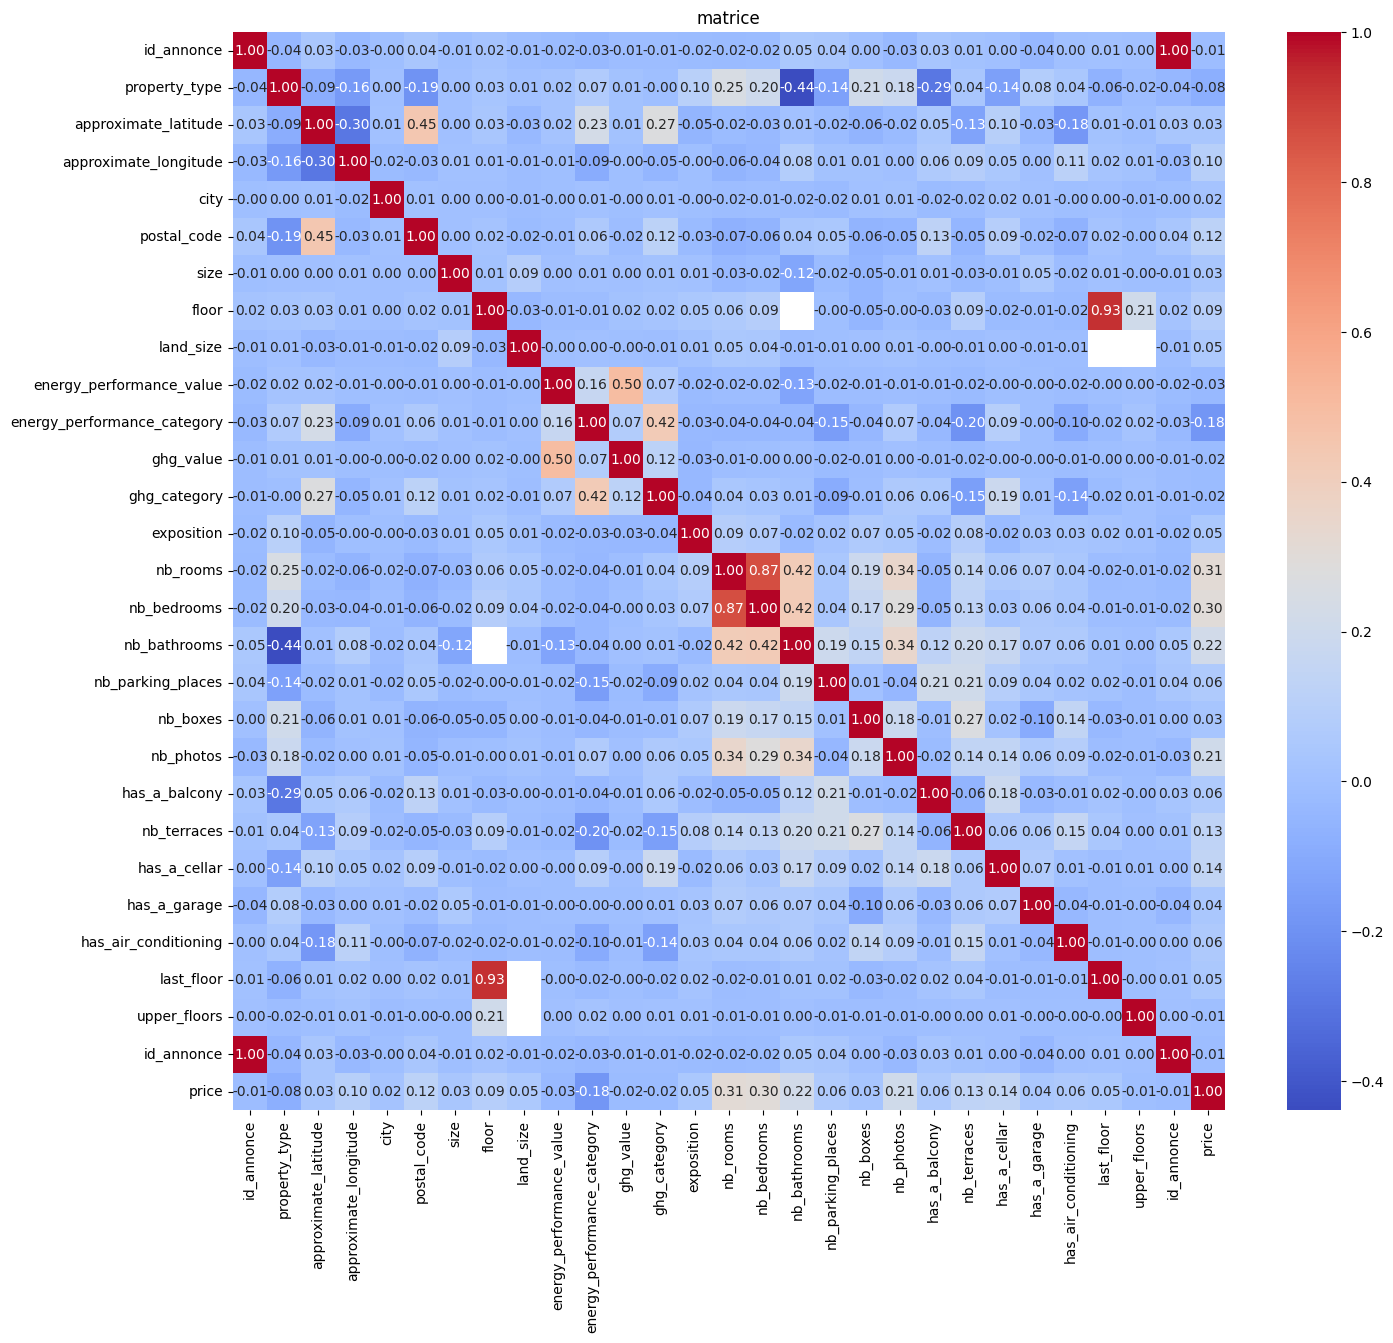

In [4]:
concatene = pd.concat([data_features_train, data_target_train], axis=1)
from sklearn.preprocessing import OrdinalEncoder
col = concatene.select_dtypes(include=['object']).columns
encoder = OrdinalEncoder()
concatene[col] = encoder.fit_transform(concatene[col])
mat = concatene.corr()
plt.figure(figsize=(16,14))
sns.heatmap(mat, annot = True, fmt = '.2f', cmap = 'coolwarm')
plt.title('matrice')
plt.show

In [5]:
def lab_enc(df, col):
    dico = {np.nan : 0, 'A' : 1, 'B' : 2, 'C' : 3, 'D' : 4, 'E' : 5, 'F' : 6, 'G' : 7}
    df[col] = df[col].map(dico)
    return df

In [6]:
def lab_enc1(df, col, dico=None):
    if dico is None : 
        liste = df[col].unique().tolist()  
        #if np.nan not in liste:  
        #    liste.append(np.nan)  
        #liste.insert(0, liste.pop(liste.index(np.nan))) 
        dico = {v: k for k, v in enumerate(liste)}
    df[col] = df[col].map(dico) 
                
    return df, dico 

In [7]:
def impute_missing_values_knn(df, imputer=None, n_neighbors=5):
    # Sélectionner uniquement les colonnes avec des valeurs numériques
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    
    if imputer is None:  # Entraînement
        # Créer l'objet IterativeImputer
        #imputer = IterativeImputer(max_iter=10, random_state=0)
        #imputer = KNNImputer(n_neighbors=n_neighbors)
        imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
        # Appliquer l'imputation uniquement sur les colonnes numériques
        df[numeric_cols] = imputer.fit_transform(df[numeric_cols])
    else:  # Test
        # Appliquer l'imputation avec le modèle déjà entraîné
        df[numeric_cols] = imputer.transform(df[numeric_cols])
        
    return df, imputer

In [8]:
def harmonize_columns(df1, df2):
    for col in df1.columns:  # Boucle sur les colonnes du dataframe1
        if col not in df2.columns:
            df2[col] = False  # Si une colonne du dataframe1 ne se trouve pas dans le dataframe2, alors on le rajoute et toutes ses valeurs sont égales à False
    df2 = df2[df1.columns]  # Permet d'enlever les colonnes se trouvant dans le dataframe2 mais pas dans le dataframe1

    return df2  # Renvoie le dataframe 2 avec les mêmes colonnes que le dataframe1

In [80]:
X_train = data_features_train.copy()
X_test = data_features_test.copy()
y_train = data_target_train['price'].copy()

In [81]:
X_train.drop(columns=['id_annonce', 'city', 'ghg_value', 'energy_performance_category', 'exposition', 'floor', 'last_floor', 'upper_floors'], inplace=True)
X_test.drop(columns=['id_annonce', 'city', 'ghg_value', 'energy_performance_category', 'exposition', 'floor', 'last_floor', 'upper_floors'], inplace=True)
X_train, dico = lab_enc1(X_train, 'property_type', dico=None) #Applique le label encoding sur la colonne property_type
X_test = lab_enc1(X_test, 'property_type', dico)[0] #Applique le label encoding sur la colonne property_type
X_train = lab_enc(X_train, 'ghg_category') #Applique le label encoding sur la colonne ghg_category
X_test = lab_enc(X_test, 'ghg_category') #Applique le label encoding sur la colonne ghg_category
X_train, imputer = impute_missing_values_knn(X_train, imputer=None, n_neighbors=5)
X_test = impute_missing_values_knn(X_test, imputer, n_neighbors=5)[0]

In [11]:
"""
from sklearn.model_selection import RandomizedSearchCV
#xgboost = xgb.XGBRegressor()
param_dist = {
    'n_estimators': [1350, 1400, 1450],
    'learning_rate': [0.04, 0.045, 0.5],
    'max_depth': [8, 9, 10, 11, 12],
    'subsample': [0.89, 0.9, 0.91],
    'colsample_bytree': [0.7, 0.75, 0.8, 0.85, 0.9],
    'gamma': [0.09, 0.1, 0.11],
    'min_child_weight': [4, 5, 6],
    'reg_alpha': [0.0025, 0.0050, 0.0075],
    'reg_lambda': [0.00005, 0.00010, 0.00015],
    'scale_pos_weight': [4, 5, 6]
}
xgboost = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgboost, 
    param_distributions=param_dist, 
    n_iter=100, 
    cv=5, 
    scoring='neg_mean_absolute_percentage_error', 
    random_state=42, 
    verbose=1,
    n_jobs=-1  # Utiliser tous les processeurs disponibles
)

random_search.fit(X_train, y_train)

print("Best parameters found: ", random_search.best_params_)
Best parameters found:  {'subsample': 0.91, 'scale_pos_weight': 6, 'reg_lambda': 0.00015, 'reg_alpha': 0.005, 'n_estimators': 1450, 'min_child_weight': 4, 'max_depth': 10, 'learning_rate': 0.04, 'gamma': 0.11, 'colsample_bytree': 0.85}

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'subsample': 0.91, 'scale_pos_weight': 6, 'reg_lambda': 0.00015, 'reg_alpha': 0.005, 'n_estimators': 1450, 'min_child_weight': 4, 'max_depth': 10, 'learning_rate': 0.04, 'gamma': 0.11, 'colsample_bytree': 0.85}


In [82]:
best_params = {
    'subsample': 0.91,
    'scale_pos_weight': 6,
    'reg_lambda': 0.00015,
    'reg_alpha': 0.005,
    'n_estimators': 1600,
    'min_child_weight': 4,
    'max_depth': 10,
    'learning_rate': 0.04,
    'gamma': 0.11,
    'colsample_bytree': 0.85,
    'objective': 'reg:squarederror',  # Assurez-vous d'inclure l'objectif
    'random_state': 42  # Pour assurer la reproductibilité
}

xgb_model = xgb.XGBRegressor(**best_params)
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.85, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.11, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.04, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1600, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [83]:
def harmonize_columns(df1, df2):
    for col in df1.columns:  # Boucle sur les colonnes du dataframe1
        if col not in df2.columns:
            df2[col] = False  # Si une colonne du dataframe1 ne se trouve pas dans le dataframe2, alors on le rajoute et toutes ses valeurs sont égales à False
    df2 = df2[df1.columns]  # Permet d'enlever les colonnes se trouvant dans le dataframe2 mais pas dans le dataframe1

    return df2  # Renvoie le dataframe 2 avec les mêmes colonnes que le dataframe1

X_test = harmonize_columns(X_train, X_test)  # Permet que X_test ait les mêmes colonnes que X_train

In [84]:
y_pred = xgb_model.predict(X_test)
predictions_df = pd.DataFrame({
    'id_annonce': data_features_test['id_annonce'].values,  # Utiliser .values pour garantir une forme 1D
    'price': y_pred
})

In [85]:
predictions_df.to_csv('predictions.csv', index=False)